# Simulate force profiles for a blue-detuned MOT for CaOH

In [1]:
using Revise

In [2]:
using QuantumStates, OpticalBlochEquations, DifferentialEquations

┌ Info: Precompiling QuantumStates [17f0441f-15e0-42ae-a101-302633ff8f0f]
└ @ Base loading.jl:1423
┌ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]
└ @ Base loading.jl:1423
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]
│   exception = ErrorException("Required dependency Sundials [c3572dad-4567-51f8-b174-8c6c989267f4] failed to load from a cache file.")
└ @ Base loading.jl:1132


### Reproduce Fig. 1 from "Blue-Detuned Magneto-Optical Trap" (PRL 120, 083201 (2018))
* Values are from Steck notes of the 87Rb D2 line
* Energies are in MHz

In [3]:
λ = 780.241209686e-9
Γ = 2π * 6.065e6 # in units of MHz
m = @with_unit 87 "u"
k = 2π / λ
;

$5^2S_{1/2}$ state

In [4]:
# F = 1
QN_bounds = (E = 0.0, F = 1)
F1_lower = enumerate_states(AngularMomentumState, QN_bounds)

# F = 2
QN_bounds = (E = 6.83468261090429e9, F = 2) # GHz (in units of MHz)
F2_lower = enumerate_states(AngularMomentumState, QN_bounds)
;

$5^2P_{3/2}$

In [5]:
E_upper = 384.2304844685e12 # THz (in units of MHz)

# F = 1
QN_bounds = (E = E_upper - 72.9113e6 - 156.947e6, F = 1)
F1_upper = enumerate_states(AngularMomentumState, QN_bounds)

# F = 2
QN_bounds = (E = E_upper - 72.9113e6, F = 2)
F2_upper = enumerate_states(AngularMomentumState, QN_bounds)
;

In [6]:
ground_states = [F1_lower; F2_lower]
excited_states = [F1_upper; F2_upper]
states = [ground_states; excited_states]
;

In [7]:
d = zeros(length(states), length(states), 3)
for (i, state) in enumerate(ground_states)
    for (j, state′) in enumerate(excited_states)
        j += length(ground_states)
        for p in -1:1
            tdm = TDM(state, state′, p)
            d[i,j,p+2] = tdm
            d[j,i,p+2] = conj(tdm)
        end
    end
end

# Magnetic moments in units of MHz/G
# For now, only assuming a field along the z axis
d_m = zeros(length(states), length(states), 3)
for (i, state) in enumerate(states)
    for (j, state′) in enumerate(states)
        for p ∈ -1:1
            tdm = TDM_magnetic(state, state′, p) * (state.E == state′.E)
            d_m[i,j,p+2] = tdm
        end
    end
end
d_m .+= permutedims(d_m, (2,1,3))
d_m[1:3,1:3,:]     .*= (-1/2)
d_m[4:8,4:8,:]     .*= ( 1/2)
d_m[9:11,9:11,:]   .*= (2/3)
d_m[12:16,12:16,:] .*= (2/3)
d_m ./= (Γ / (μB * 1e6))
;

In [8]:
# Laser parameters
δf11 = +11.5e6
δf22 = +26.0e6
θ₁ = 0.0
θ₂ = 0.0

s = 20

pol = σ⁺

# Create MOT beams for F=1 -> F'=1 transition
ω_F1_to_F1 = 2π * (F1_upper[1].E - F1_lower[1].E + δf11)

k̂ = +x̂
ϵ = exp(im * θ₁) * rotate_pol(pol, k̂)
laser1 = Laser(k̂, ϵ, ω_F1_to_F1, s)

k̂ = -x̂
ϵ = exp(im * θ₁) * rotate_pol(pol, k̂)
laser2 = Laser(k̂, ϵ, ω_F1_to_F1, s)

k̂ = +ŷ
ϵ = exp(im * θ₂) * rotate_pol(pol, k̂)
laser3 = Laser(k̂, ϵ, ω_F1_to_F1, s)

k̂ = -ŷ
ϵ = exp(im * θ₂) * rotate_pol(pol, k̂)
laser4 = Laser(k̂, ϵ, ω_F1_to_F1, s)

k̂ = +ẑ
ϵ = rotate_pol(pol, k̂)
laser5 = Laser(k̂, ϵ, ω_F1_to_F1, s)

k̂ = -ẑ
ϵ = rotate_pol(pol, k̂)
laser6 = Laser(k̂, ϵ, ω_F1_to_F1, s)

# Create MOT beams for F=2 -> F'=2 transition
ω_F2_to_F2 = 2π * (F2_upper[1].E - F2_lower[1].E + δf22)

k̂ = +x̂
ϵ = exp(im * θ₁) * rotate_pol(pol, k̂)
laser7 = Laser(k̂, ϵ, ω_F2_to_F2, s)

k̂ = -x̂
ϵ = exp(im * θ₁) * rotate_pol(pol, k̂)
laser8 = Laser(k̂, ϵ, ω_F2_to_F2, s)

k̂ = +ŷ
ϵ = exp(im * θ₂) * rotate_pol(pol, k̂)
laser9 = Laser(k̂, ϵ, ω_F2_to_F2, s)

k̂ = -ŷ
ϵ = exp(im * θ₂) * rotate_pol(pol, k̂)
laser10 = Laser(k̂, ϵ, ω_F2_to_F2, s)

k̂ = +ẑ
ϵ = rotate_pol(pol, k̂)
laser11 = Laser(k̂, ϵ, ω_F2_to_F2, s)

k̂ = -ẑ
ϵ = rotate_pol(pol, k̂)
laser12 = Laser(k̂, ϵ, ω_F2_to_F2, s)

lasers = [laser1, laser2, laser3, laser4, laser5, laser6, laser7, laser8, laser9, laser10, laser11, laser12]
# lasers = [laser5, laser6, laser11, laser12] # only z beams
;

In [9]:
freq_res = 1e-1
ω_min = freq_res
period = 2π / ω_min

ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[3,3] = 1.0

particle = Particle()
particle.r0 = [0.0, 0.0, 0.0]
particle.v = [0.0, 0.0, 2.0] # velocity is in Γ / k in the simulation, so need to multiply by this for m/s
    
# Define magnetic field
B(r) = (87e2) .* (r[1], r[2], -2r[3]) # B′ = 87 G/cm
magnetic_field = B

(dρ, ρ, p) = obe(particle, states, lasers, magnetic_field, d, d_m, ρ0, true, true, λ=λ, Γ=Γ, freq_res=freq_res)
ρ!(dρ, ρ0, p, 0.0)
p.B = (0.0, 0.0, 0.0)
;

In [10]:
# using BenchmarkTools
# @btime ρ!(dρ, ρ0, p, 0.0)

In [11]:
t_end = 200
tspan = (0., t_end)
times = range(tspan[1], tspan[2], 300000)

prob = ODEProblem(ρ!, ρ0, tspan, p) # callback=AutoAbstol(false, init_curmax=0.0)) # what does this do?
;

In [12]:
@time sol = DifferentialEquations.solve(prob, alg=DP5(), saveat=times);

  5.241986 seconds (7.45 M allocations: 1.568 GiB, 9.72% gc time, 58.29% compilation time)


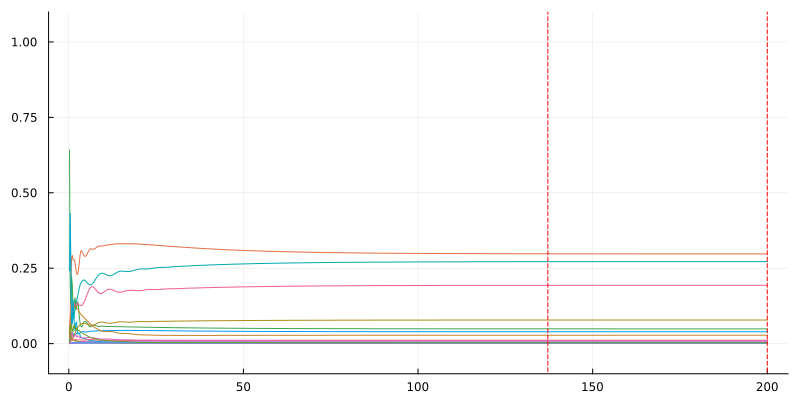

In [13]:
using Plots
plot_idxs = convert.(Int64, range(0, length(times), 1001))[2:end]
plot_us = sol.u[plot_idxs]
plot_ts = sol.t[plot_idxs]

plot(plot_ts, [real(u[1,1]) for u in plot_us], size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 2:size(sol.u[1], 1)
    plot!(plot_ts, [real(u[i,i]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - period - offset, sol.t[end] - offset], color="red", linestyle=:dash)
# vline!([280, 380], color="red", linestyle=:dash)

In [15]:
using Statistics, LinearAlgebra
offset = 1000
period_idx = find_idx_for_time(p.period, sol.t, true)
force_idxs = (period_idx - offset):(length(times) - offset)

@time F = calculate_force_from_period(p, sol)
println("Excited population: ", real(sum(diag(mean(sol.u[period_idx:end]))[13:end])))
println("Force: ", 1e3 .* F) #sign.(force) .* abs(force ⋅ p.particle.v) / norm(p.particle.v))
println("Acceleration (10^3 m/s^2): ", 1e-3 * QuantumStates.ħ * p.k * Γ * F / m)

  1.155811 seconds (1 allocation: 32 bytes)
Excited population: 0.027954595218227903
Force: [2.1008623547428025, -4.077342209160323, -19.032141227099707]
Acceleration (10^3 m/s^2): [0.47061641088515394, -0.9133697655601488, -4.263410201785243]


#### Force versus velocity

In [62]:
scan_params = Dict(
    :v => ((0.0, 0.0, v / (Γ / k)) for v ∈ 0:1:10),
    :r => ((0.1, 0.5, 0.0),),
    :B => ((0.0, 0.0, 0.0),)
)
;

In [63]:
iterator_info, forces = force_scan(p, scan_params, nthreads=2);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


In [64]:
vs, averaged_forces = average_forces(iterator_info, forces, :v, v -> v[3], f -> f[3]);

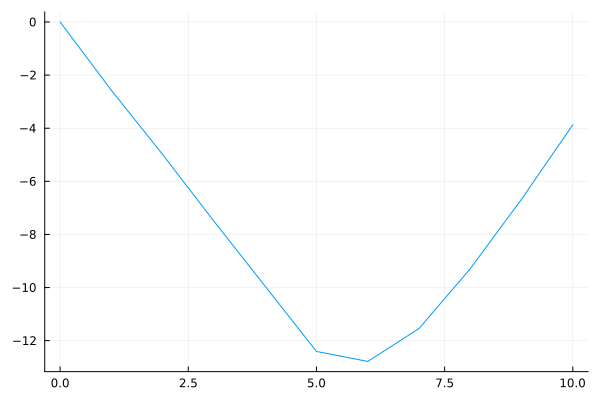

┌ Warning: X:\My Drive\github\OpticalBlochEquations\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\Christian Hallas\.julia\packages\Revise\do2nH\src\packagedef.jl:570
┌ Warning: X:\My Drive\github\QuantumStates\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\Christian Hallas\.julia\packages\Revise\do2nH\src\packagedef.jl:570


In [65]:
plot(vs .* (Γ / k), (1e-3 * QuantumStates.ħ * k * Γ / m) .* averaged_forces, legend=nothing)

#### Force versus position

In [134]:
function sample_direction()
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (sqrt(1 - z^2) * cos(θ), sqrt(1 - z^2) * sin(θ), z)
end;

In [135]:
# scan_params = Dict(:B => ((0.0, 0.0, B_z) for B_z ∈ 0:2.0:200.0), :v => ((0.0 / (1e6 * Γ / k)) .* sample_direction() for _ ∈ 1:1))
scan_params = Dict(
    :B => ((0.0, 0.0, B_z) for B_z ∈ 0:10.0:500.0), 
    :v => ((0.0, 0.0, 0.0),), #(v / (1e6 * Γ / k), 0.0, 0.0) for v ∈ [-1.0, 1.0]),
    :r0 => ((0.9, 0.0, 0.1),)
)
;

In [136]:
@time iterator_info, forces = force_scan(p, scan_params, nthreads=5);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


  4.636239 seconds (805.98 k allocations: 251.266 MiB, 6.63% compilation time)


In [25]:
Bs, averaged_forces = average_forces(iterator_info, forces, :B, B -> B[3], f -> f[3]);

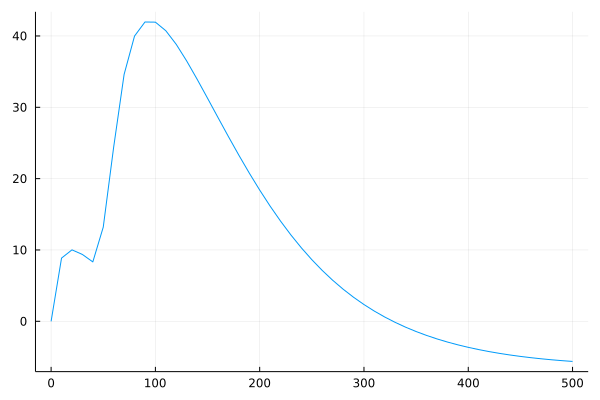

In [138]:
plot(Bs, (1e-3 * QuantumStates.ħ * k * Γ / m) .* averaged_forces, legend=nothing)

### Reproduce Fig. 6 from (New J. Phys. 18, 123017 (2016))

In [30]:
λ = 1
Γ = 2π
m = 1
k_norm = 2π / λ
;

In [31]:
# F = 1
QN_bounds = (E = 0.0, F = 1)
F1_lower = enumerate_states(AngularMomentumState, QN_bounds)
QN_bounds = (E = 1.0, F = 1)
F1_upper = enumerate_states(AngularMomentumState, QN_bounds)
;

In [32]:
ground_states = F1_lower
excited_states = F1_upper
states = [ground_states; excited_states]
;

In [33]:
d = zeros(length(states), length(states), 3)
for (i, state) in enumerate(ground_states)
    for (j, state′) in enumerate(excited_states)
        j += length(ground_states)
        for p in -1:1
            tdm = TDM(state, state′, p)
            d[i,j,p+2] = tdm
            d[j,i,p+2] = conj(tdm)
        end
    end
end

# Magnetic moments in units of MHz/G
# For now, only assuming a field along the z axis
d_m = zeros(length(states), length(states), 3)
for (i, state) in enumerate(states)
    for (j, state′) in enumerate(states)
        for p ∈ -1:1
            tdm = TDM_magnetic(state, state′, p) * (state.E == state′.E)
            d_m[i,j,p+2] = tdm
            # d_m[j,i,p+2] = conj(tdm)
        end
    end
end
d_m .+= permutedims(d_m, (2,1,3))
d_m ./= Γ
;

In [259]:
# Laser parameters
Δ = -2.5Γ
s = 2.0
θ₁ = 0.0
θ₂ = 0.0

# Create MOT beams for F=1 -> F'=1 transition
ω_F1_to_F1 = 2π * (F1_upper[1].E - F1_lower[1].E) + Δ

k = +x̂
ϵ = exp(im * θ₁) * rotate_pol(σ⁺, k)
laser1 = Laser(k, ϵ, ω_F1_to_F1, s)

k = -x̂
ϵ = exp(im * θ₁) * rotate_pol(σ⁺, k)
laser2 = Laser(k, ϵ, ω_F1_to_F1, s)

k = +ŷ
ϵ = exp(im * θ₂) * rotate_pol(σ⁺, k)
laser3 = Laser(k, ϵ, ω_F1_to_F1, s)

k = -ŷ
ϵ = exp(im * θ₂) * rotate_pol(σ⁺, k)
laser4 = Laser(k, ϵ, ω_F1_to_F1, s)

k = +ẑ
ϵ = rotate_pol(σ⁺, k)
laser5 = Laser(k, ϵ, ω_F1_to_F1, s)

k = -ẑ
ϵ = rotate_pol(σ⁺, k)
laser6 = Laser(k, ϵ, ω_F1_to_F1, s)

# lasers = [laser1, laser2, laser3, laser4, laser5, laser6]
# lasers = [laser1, laser2]
# lasers = [laser3, laser4]
lasers = [laser5, laser6]
;

In [287]:
freq_res = 1e-2
ω_min = freq_res
period = 2π / ω_min

ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[2,2] = 1.0

particle = Particle()
particle.r0 = [0.0, 0.0, 0.0]# ./ k_norm
particle.v = [0.0, 0.0, 1.0]

# Define magnetic field
B(r) = (0.0, 0.0, 0.0) #(r[1], r[2], -2r[3]) # B′ = 87 G/cm
magnetic_field = B

(dρ, ρ, p) = obe(particle, states, lasers, magnetic_field, d, d_m, ρ0, true, true, λ=λ, Γ=Γ, freq_res=freq_res)
;

In [288]:
# using BenchmarkTools
# @btime ρ!(dρ, ρ0, p, 0.0)

In [289]:
t_end = 2000.0
tspan = (0., t_end)
times = range(0., tspan[2], 1000)

prob = ODEProblem(ρ!, ρ0, tspan, p)#, callback=AutoAbstol(false, init_curmax=0.0)) # what does this do?
;

In [291]:
@time sol = DifferentialEquations.solve(prob, alg=DP5(), saveat=times);

  0.033381 seconds (1.04 k allocations: 715.281 KiB)


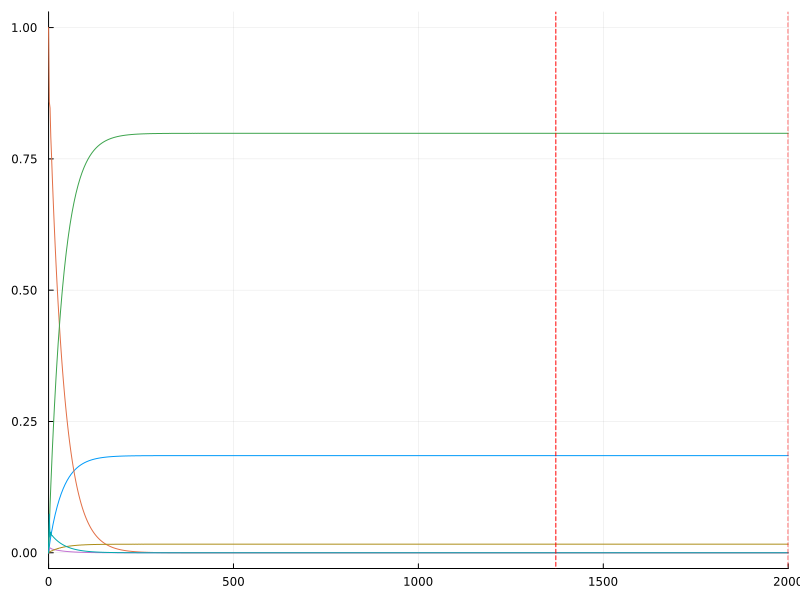

In [292]:
using Plots
plot_idxs = convert.(Int64, range(0, length(times), 1001))[2:end]
plot_us = sol.u[plot_idxs]
plot_ts = sol.t[plot_idxs]

plot(plot_ts, [norm(u[1,1]) for u ∈ plot_us], size=(800, 600), xlim=(0.0,t_end), legend=nothing)
for i ∈ 2:size(sol.u[1], 1)
    plot!(plot_ts, [norm(u[i,i]) for u ∈ plot_us])
end
offset = 0
vline!([sol.t[end] - period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [294]:
using Statistics, LinearAlgebra
offset = 1000
period_idx = find_idx_for_time(p.period, sol.t, true)
force_idxs = (period_idx - offset):(length(times) - offset)

@time F = calculate_force_from_period(p, sol)
println("Excited population: ", real(sum(diag(mean(sol.u[period_idx:end]))[4:end])))
println("Force: ", 1e3 .* F) #sign.(force) .* abs(force ⋅ p.particle.v) / norm(p.particle.v))
println("Acceleration (10^3 m/s^2): ", 1e-3 * QuantumStates.ħ * k_norm * Γ * F / m)

  0.000349 seconds (1 allocation: 32 bytes)
Excited population: 0.016358131772947086
Force: [0.0, 0.0, -0.5607477224567661]
Acceleration (10^3 m/s^2): [0.0, 0.0, -2.3345512701455455e-39]


#### Force versus velocity

In [27]:
rs = 0:1/8:0.9
scan_params = Dict(:v => ((v_x, 0.0, 0.1) for v_x ∈ 0:0.25:7.0), :r0 => ((r_x, r_y, r_z) for r_x ∈ rs, r_y ∈ rs, r_z ∈ rs));

In [28]:
iterator_info, forces = force_scan(p, scan_params);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:18


In [24]:
function average_forces(iterator_info, forces, param_to_average, f_value, f_average)
    params, iterator = iterator_info
    param_idx = params .== param_to_average
    typeof_param = typeof(first(iterator)[param_idx][1])
    forces_dict = Dict{typeof_param, Tuple{Int64, Float64}}()
    for (i, param) ∈ enumerate(iterator)
        force = forces[i]
        param_value = param[param_idx][1]
        if haskey(forces_dict, param_value)
            occurrences, current_force = forces_dict[param_value]
            forces_dict[param_value] = (occurrences + 1, current_force + f_average(force))
        else
            forces_dict[param_value] = (1, f_average(force))
        end
    end
    unique_values = f_value.(keys(forces_dict))
    forces_with_occurrences = collect(values(forces_dict))
    averaged_forces = [x[2] / x[1] for x in forces_with_occurrences]
    
    sorted_idxs = sortperm(unique_values)
    return unique_values[sorted_idxs], averaged_forces[sorted_idxs]
end

average_forces (generic function with 1 method)

In [33]:
vs, averaged_forces = average_forces(iterator_info, forces, :v, v -> v[1], f -> f[1]);

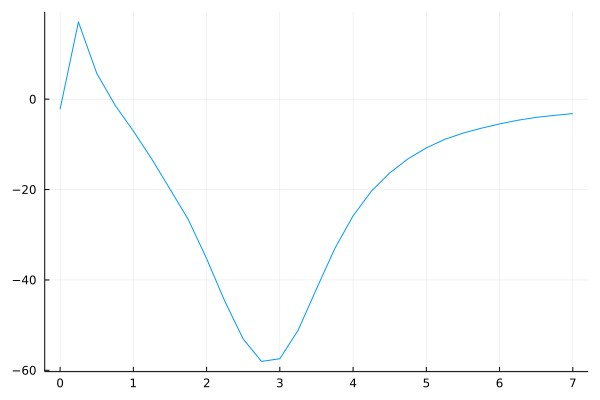

In [34]:
plot(vs, 1e3 .* averaged_forces, xticks=-7:7, legend=nothing)

#### Force versus magnetic field

In [147]:
function sample_direction()
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (sqrt(1 - z^2) * cos(θ), sqrt(1 - z^2) * sin(θ), z)
end;

In [177]:
scan_params = Dict(:B => ((0,0,B_z) for B_z ∈ 0:0.1:2.0), :v => (0.1 .* sample_direction() for _ ∈ 1:100))
;

In [178]:
@time iterator_info, forces = force_scan(p, scan_params);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


 15.646093 seconds (3.32 M allocations: 1.496 GiB, 0.29% gc time, 2.53% compilation time)


In [179]:
vs, averaged_forces = average_forces(iterator_info, forces, :B, B -> B[3], f -> f[3]);

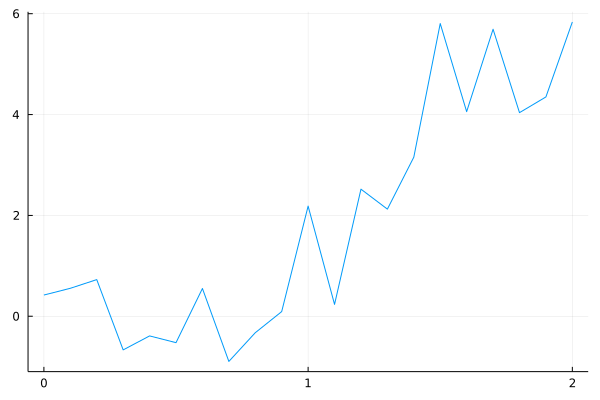

In [180]:
plot(vs, 1e3 .* averaged_forces, xticks=-7:7, legend=nothing)

##### Attempt dense output for the force

In [3110]:
# Dense output, how does it compare?
@time sol = DifferentialEquations.solve(prob, alg=DP5(), abstol=1e-6, reltol=1e-7, dense=true);

  0.205279 seconds (338.70 k allocations: 1.073 GiB, 41.16% gc time)


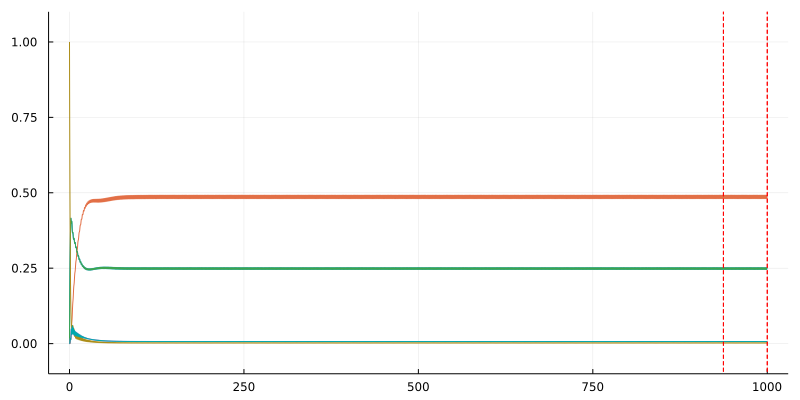

In [3111]:
for i in 1:6
    plot!(i, [real(sol(j)[i,i]) for j in 1:p.period])
end
plot!()
offset = 0
vline!([sol.t[end] - period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [3112]:
ts = 500:0.001:1000
sum(sol(t) for t ∈ ts) ./ length(ts) |> diag

6-element Vector{ComplexF64}:
   0.24883767685787198 + 0.0im
    0.4863119840409715 + 0.0im
     0.248837676857872 + 0.0im
  0.006863770406026248 + 0.0im
 0.0022851214312301607 + 0.0im
  0.006863770406026251 + 0.0im

### CaOH

In [170]:
λ = 626e-9
Γ = 2π * 6.4e6 # in units of MHz
m = @with_unit 57 "u"
k = 2π / λ
;

##### Load $\widetilde{X}(000)$ and $\widetilde{A}(000)$ Hamiltonians

In [287]:
HX = load_from_file("CaOH_000_N0to3_Hamiltonian", "X://My Drive//github//QuantumStates//Hamiltonians//")
HA = load_from_file("CaOH_A000_J12to52_Hamiltonian", "X://My Drive//github//QuantumStates//Hamiltonians//")

_, states_X_N1 = subspace(HX.states, (N=1,))
_, states_A_J12 = subspace(HA_0.states, (Ω=1/2, J=1/2,))

HX_0110 = load_from_file("CaOH_BendingMode_Hamiltonian", "X://My Drive//github//QuantumStates//Hamiltonians//")
states_A_J12_caseB = convert_basis(states_A_J12, HX_0110.basis)

ground_states = states_X_N1
for state ∈ ground_states
    state.E *= 1e6
end
excited_states = states_A_J12_caseB
for state ∈ excited_states
    state.E *= 1e6
    state.E += QuantumStates.c / λ
end
states = [ground_states; excited_states]
;

In [463]:
d = zeros(length(states), length(states), 3)
for (i, state) in enumerate(ground_states)
    for (j, state′) in enumerate(excited_states)
        j += length(ground_states)
        for p in -1:1
            tdm = TDM(state, state′, p)
            d[i,j,p+2] = tdm
            d[j,i,p+2] = conj(tdm)
        end
    end
end

# Magnetic moments in units of MHz/G
# For now, only assuming a field along the z axis
d_m = zeros(length(states), length(states), 3)
for (i, state) in enumerate(states)
    for (j, state′) in enumerate(states)
        for p ∈ -1:1
            tdm = TDM_magnetic(state, state′, p) * (state.E == state′.E)
            d_m[i,j,p+2] = tdm
        end
    end
end
d_m .+= permutedims(d_m, (2,1,3))
d_m ./= (Γ / (μB * 1e6))
;

In [852]:
# Laser parameters
J12_energy = energy(ground_states[1])
J32_energy = energy(ground_states[5])
A_energy = energy(excited_states[1])

δJ12 = -13.0e6
δJ32 = -13.0e6
θ₁ = 0.0
θ₂ = 0.0
s_J12 = 20.0
s_J32 = 20.0
pol = σ⁺

ω_J12 = 2π * (A_energy - J12_energy + δJ12)

k̂ = +x̂
ϵ = exp(im * θ₁) * rotate_pol(pol, k̂)
laser1 = Laser(k̂, ϵ, ω_J12, s_J12)

k̂ = -x̂
ϵ = exp(im * θ₁) * rotate_pol(pol, k̂)
laser2 = Laser(k̂, ϵ, ω_J12, s_J12)

k̂ = +ŷ
ϵ = exp(im * θ₂) * rotate_pol(pol, k̂)
laser3 = Laser(k̂, ϵ, ω_J12, s_J12)

k̂ = -ŷ
ϵ = exp(im * θ₂) * rotate_pol(pol, k̂)
laser4 = Laser(k̂, ϵ, ω_J12, s_J12)

k̂ = +ẑ
ϵ = rotate_pol(pol, k̂)
laser5 = Laser(k̂, ϵ, ω_J12, s_J12)

k̂ = -ẑ
ϵ = rotate_pol(pol, k̂)
laser6 = Laser(k̂, ϵ, ω_J12, s_J12)

ω_J32 = 2π * (A_energy - J32_energy + δJ32)

k̂ = +x̂
ϵ = exp(im * θ₁) * rotate_pol(pol, k̂)
laser7 = Laser(k̂, ϵ, ω_J32, s_J32)

k̂ = -x̂
ϵ = exp(im * θ₁) * rotate_pol(pol, k̂)
laser8 = Laser(k̂, ϵ, ω_J32, s_J32)

k̂ = +ŷ
ϵ = exp(im * θ₂) * rotate_pol(pol, k̂)
laser9 = Laser(k̂, ϵ, ω_J32, s_J32)

k̂ = -ŷ
ϵ = exp(im * θ₂) * rotate_pol(pol, k̂)
laser10 = Laser(k̂, ϵ, ω_J32, s_J32)

k̂ = +ẑ
ϵ = rotate_pol(pol, k̂)
laser11 = Laser(k̂, ϵ, ω_J32, s_J32)

k̂ = -ẑ
ϵ = rotate_pol(pol, k̂)
laser12 = Laser(k̂, ϵ, ω_J32, s_J32)

lasers = [laser1, laser2, laser3, laser4, laser5, laser6, laser7, laser8, laser9, laser10, laser11, laser12]
;

In [853]:
freq_res = 1e-1
ω_min = freq_res
period = 2π / ω_min

ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[1,1] = 1.0

particle = Particle()
particle.r0 = [0.0, 0.0, 0.0]
particle.v = [0.0, 0.0, 30.0] # velocity is in Γ / k in the simulation, so need to multiply by this for m/s
    
# Define magnetic field
# B(r) = (87e2) .* (r[1], r[2], -2r[3]) # B′ = 87 G/cm
# magnetic_field = B
p.B = (0.0, 0.0, 0.0)

(dρ, ρ, p) = obe(particle, states, lasers, magnetic_field, d, d_m, ρ0, true, true, λ=λ, Γ=Γ, freq_res=freq_res)
;

In [854]:
# using BenchmarkTools
# @btime ρ!(dρ, ρ0, p, 0.0)

In [855]:
t_end = 5000
tspan = (0., t_end)
times = range(tspan[1], tspan[2], 1000)

prob = ODEProblem(ρ!, ρ0, tspan, p) #, callback=AutoAbstol(false, init_curmax=0.0)) # what does this do?
;

In [856]:
@time sol = DifferentialEquations.solve(prob, alg=DP5(), saveat=times);

  0.901766 seconds (1.05 k allocations: 4.141 MiB)


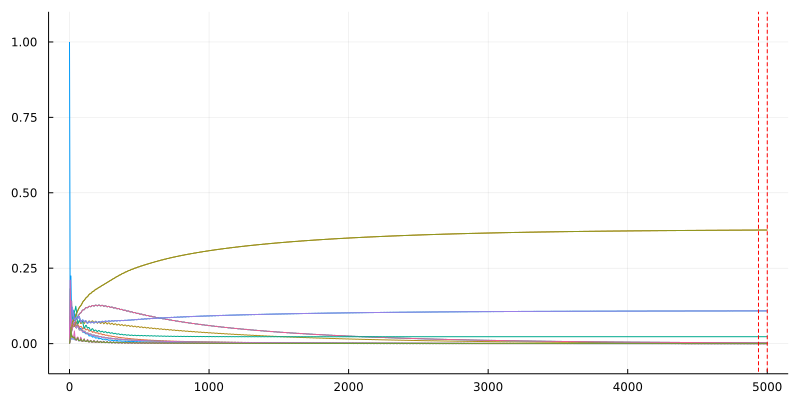

In [857]:
using Plots
plot_idxs = convert.(Int64, range(0, length(times), 1001))[2:end]
plot_us = sol.u[plot_idxs]
plot_ts = sol.t[plot_idxs]

plot(plot_ts, [real(u[1,1]) for u in plot_us], size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 2:size(sol.u[1], 1)
    plot!(plot_ts, [real(u[i,i]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - period - offset, sol.t[end] - offset], color="red", linestyle=:dash)
# vline!([280, 380], color="red", linestyle=:dash)

In [858]:
using Statistics, LinearAlgebra
offset = 0
period_idx = find_idx_for_time(period, sol.t, true)
force_idxs = (period_idx - offset):(length(times) - offset)
@time force = calculate_force_from_period(p, sol; force_idxs)

# @time force = calculate_force_from_period(p, sol)
# println("Excited population: ", real(sum(diag(mean(sol.u[force_idxs]))[9:end])))
println("Force: ", force)
println("Acceleration (10^3 m/s^2): ", 1e-3 * QuantumStates.ħ * k * Γ * force[3] / m)

  0.001453 seconds (3 allocations: 96 bytes)
Force: [0.00038108880612398307, 2.81909452565617e-19, -1.0240257259081699e-18]
Acceleration (10^3 m/s^2): -4.604987468472632e-16


#### Force versus velocity

In [859]:
scan_params = Dict(
    :v => ((3.0 / (Γ / k), 0.0, v / (Γ / k)) for v ∈ 0:1.0:100),
    :r => ((0.0, 0.0, 0.0),),
    :B => ((0.0, 0.0, 0.0),)
)
;

In [860]:
iterator_info, forces = force_scan(p, scan_params, nthreads=5);

In [861]:
vs, averaged_forces = average_forces(iterator_info, forces, :v, v -> v[3], f -> f[3]);

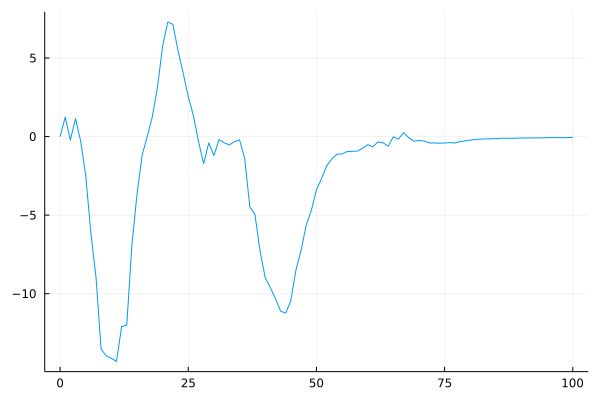

In [862]:
plot(vs .* (Γ / k), (1e-3 * QuantumStates.ħ * k * Γ / m) .* averaged_forces, legend=nothing)

#### Force versus magnetic field

In [767]:
function sample_direction()
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (sqrt(1 - z^2) * cos(θ), sqrt(1 - z^2) * sin(θ), z)
end;

In [782]:
# scan_params = Dict(:B => ((0.0, 0.0, B_z) for B_z ∈ 0:2.0:200.0), :v => ((0.0 / (1e6 * Γ / k)) .* sample_direction() for _ ∈ 1:1))
scan_params = Dict(
    :B => ((0.0, 0.0, B_z) for B_z ∈ 0:10.0:500.0),
    :v => ((0.0, 0.0, 0.0),), #(v / (1e6 * Γ / k), 0.0, 0.0) for v ∈ [-1.0, 1.0]),
    :r0 => ((0.9, 0.0, 0.1),)
)
;

In [783]:
@time iterator_info, forces = force_scan(p, scan_params, nthreads=5);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


 17.332074 seconds (819.18 k allocations: 251.971 MiB, 1.75% compilation time)


In [784]:
Bs, averaged_forces = average_forces(iterator_info, forces, :B, B -> B[3], f -> f[3]);

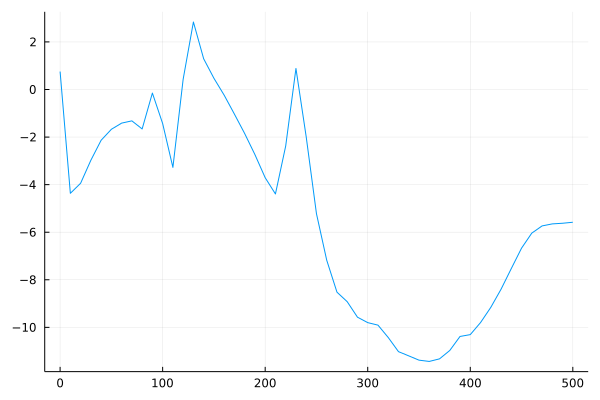

In [785]:
plot(Bs, (1e-3 * QuantumStates.ħ * k * Γ / m) .* averaged_forces, legend=nothing)